In [11]:
import pandas as pd
import numpy as np

users = pd.read_csv('game_data/users.csv')
recoms = pd.read_csv('game_data/recommendations.csv')
games = pd.read_csv('game_data/games.csv')
games_metadata = pd.read_json('game_data/games_metadata.json', lines=True)
games_metadata.head()

games = games.drop(columns=['price_final', 'discount', 'steam_deck'])
games_metadata = games_metadata.drop(columns=['description'])

gamesF = pd.merge(games, games_metadata, on='app_id')
ratings = recoms.drop(columns=['funny', 'review_id', 'date'])
ratings['is_recommended'] = ratings['is_recommended'].astype(int)

In [ ]:
# Remove apps from gameF where number of tags == 0
gamesF['num_tags'] = gamesF['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
bad_app_ids = gamesF.loc[gamesF['num_tags'] == 0, 'app_id']
gamesF = gamesF.loc[gamesF['num_tags'] > 0].drop(columns=['num_tags'])
# gamesF = gamesF[gamesF['num_tags'] > 0]

# Remove entries from ratings where app_id have number of tags == 0
ratings_to_remove = ratings[ratings['app_id'].isin(bad_app_ids)]
ratings = ratings[~ratings['app_id'].isin(bad_app_ids)]

# Adjust the 'reviews' count in the users dataframe
counts_to_decrement = ratings_to_remove['user_id'].value_counts()
users = users.set_index('user_id')
users['reviews'] = (users['reviews'] - counts_to_decrement).fillna(users['reviews']).astype(int)
users['reviews'] = users['reviews'].clip(lower=0)
users = users.reset_index()

### Remove user who reviewed least than 80 games

In [13]:
users = users[users['reviews']>=80]

In [14]:
filtered_ratings = ratings[ratings['user_id'].isin(users['user_id'])]

print(f"Original number of rows in ratings: {len(ratings)}")
print(f"Number of rows in filtered ratings: {len(filtered_ratings)}")

Original number of rows in ratings: 20349080
Number of rows in filtered ratings: 1290394


In [15]:
gamesF = gamesF[gamesF['app_id'].isin(filtered_ratings['app_id'].unique())]

### Remove the user who dislike no game, mean like everygame they review

In [16]:
only_likes = filtered_ratings.groupby('user_id')['is_recommended'].apply(lambda x: (x == 1).all())
users_to_remove = only_likes[only_likes].index

users = users[~users['user_id'].isin(users_to_remove)]

users

,user_id,products,reviews
254,6366584,1597,107
527,11402551,444,108
1477,5047735,1941,113
1546,5337314,1252,182
1555,5382866,2723,87
...,...,...,...
14270617,8340518,433,102
14271082,8458227,405,214
14272163,8706224,211,95
14272431,8769179,449,111


In [17]:
filtered_ratings1 = filtered_ratings[filtered_ratings['user_id'].isin(users['user_id'])]

print(f"Original number of rows in ratings: {len(ratings)}")
print(f"Number of rows in filtered ratings: {len(filtered_ratings1)}")

Original number of rows in ratings: 20349080
Number of rows in filtered ratings: 1216815


In [20]:
gamesF = gamesF[gamesF['app_id'].isin(filtered_ratings1['app_id'].unique())]

In [21]:
gamesF

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_original,tags
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,"[Action, Adventure, Parkour, Third Person, Gre..."
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
5,250180,METAL SLUG 3,2015-09-14,True,False,False,Very Positive,90,5579,7.99,"[Arcade, Classic, Action, Co-op, Side Scroller..."
...,...,...,...,...,...,...,...,...,...,...,...
50713,1953060,Time Thief,2022-05-24,True,True,True,Very Positive,97,171,0.00,"[Action-Adventure, Action, Adventure, Explorat..."
50716,668600,Pixelum,2020-10-01,True,False,False,Mixed,41,58,0.00,"[RPG, Adventure, Simulation, Indie, Early Acce..."
50717,2071510,Goblin Rules Football,2022-10-20,True,True,True,Mostly Positive,72,11,0.00,"[Sports, Arcade, 2D, Football (American), Team..."
50738,962400,Granny,2018-11-20,True,False,False,Very Positive,90,1403,4.99,"[Horror, Survival Horror, Adventure, First-Per..."


In [22]:
gamesF[gamesF['user_reviews'] <= 10] 

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_original,tags
364,1501150,Pebble Witch,2021-01-25,True,True,False,Positive,90,10,2.99,"[RPG, Casual, Walking Simulator, LGBTQ+, Explo..."
517,1532920,Clutter IX: Clutter IXtreme,2021-03-02,True,False,False,Positive,100,10,9.99,"[Hidden Object, Casual, Puzzle, Indie, Point &..."
736,824200,The Bell Chimes for Gold,2018-04-06,True,False,False,Positive,80,10,9.99,"[Indie, Casual, Adventure, Otome, Anime, Femal..."
1176,1782860,Community College Hero: Fun and Games,2022-02-03,True,True,True,Positive,100,10,4.99,"[Adventure, RPG, Interactive Fiction, Choose Y..."
1350,1148290,Thy Kingdom Crumble,2019-09-26,True,True,True,Positive,90,10,4.99,"[Action, Indie, Action Roguelike, Roguelite, P..."
...,...,...,...,...,...,...,...,...,...,...,...
50669,1536870,High Smileson,2021-02-18,True,False,False,Positive,90,10,3.99,"[Casual, Adventure, Visual Novel, Puzzle, Expl..."
50683,321390,Zone 22,2015-07-31,True,False,False,Negative,0,10,7.99,"[Action, Indie, Early Access, Simulation, Casu..."
50686,860730,Skinscape,2018-06-09,True,False,False,Mixed,60,10,0.00,"[Free to Play, Indie, VR]"
50700,1492320,New Joe & Mac - Caveman Ninja,2022-12-01,True,False,False,Mixed,50,10,24.99,"[Side Scroller, 2D Platformer, Retro, 1990's, ..."


In [ ]:
recommendation_distribution = filtered_ratings['is_recommended'].value_counts(normalize=True) * 100
print(recommendation_distribution)

is_recommended
1    77.250049
0    22.749951
Name: proportion, dtype: float64


In [23]:
recommendation_distribution = filtered_ratings1['is_recommended'].value_counts(normalize=True) * 100
print(recommendation_distribution)

is_recommended
1    75.874393
0    24.125607
Name: proportion, dtype: float64


In [ ]:
game_path = 'game_data_prepared/games.csv'
rating_path = 'game_data_prepared/ratings.csv'
user_path ='game_data_prepared/users.csv'

gamesF.to_csv(game_path, index=False)
filtered_ratings1.to_csv(rating_path, index=False)
users.to_csv(user_path, index=False)

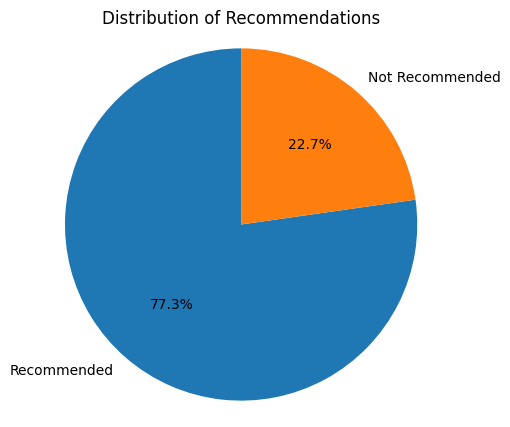

Total number of ratings: 1290394


In [27]:
import matplotlib.pyplot as plt

counts = filtered_ratings['is_recommended'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=['Recommended', 'Not Recommended'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Recommendations')
plt.axis('equal')  
plt.show()

total_ratings = counts.sum()
print(f"Total number of ratings: {total_ratings}")

In [26]:
users["products"].value_counts()

products
394     16
343     15
427     15
305     14
344     14
        ..
6428     1
1764     1
2074     1
3362     1
2688     1
Name: count, Length: 2931, dtype: int64

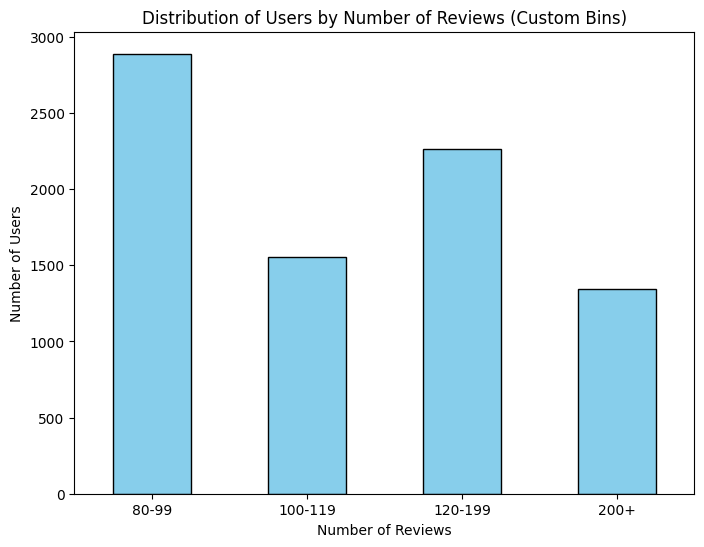

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

bins = [80, 100, 120, 200, float('inf')]
labels = ['80-99', '100-119', '120-199', '200+']
users['review_category'] = pd.cut(users['reviews'], bins=bins, labels=labels, right=False)
review_counts = users['review_category'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
review_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Users by Number of Reviews (Custom Bins)')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()


In [33]:
users = users.drop(columns=['review_category'])

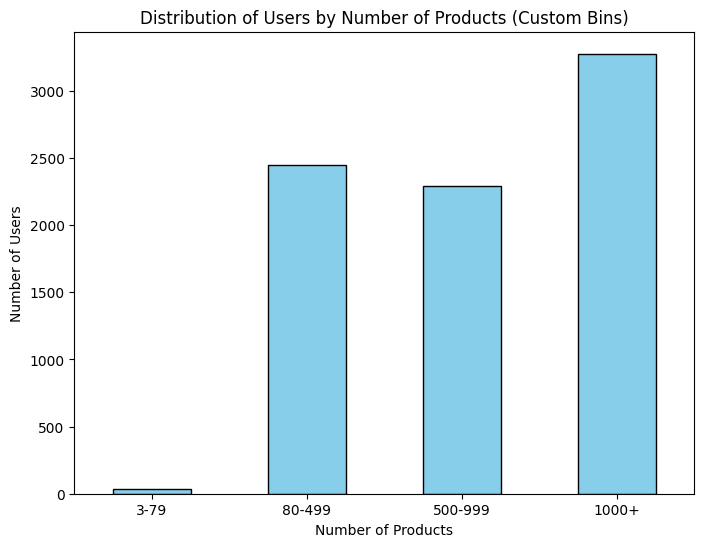

In [ ]:
bins = [3, 80, 500, 1000, float('inf')]
labels = ['3-79', '80-499', '500-999', '1000+']
users['product_category'] = pd.cut(users['products'], bins=bins, labels=labels, right=False)
review_counts = users['product_category'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
review_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Users by Number of Products (Custom Bins)')
plt.xlabel('Number of Products')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

Some people buy games less than reviews because they review by account family, mean that they dont buy game but add on games to play bi family privacy, one person in family buy that every one can play

In [45]:
users[users['products']==78]

,user_id,products,reviews,product_category
5120601,8855727,78,135,3-379


In [50]:
users

,user_id,products,reviews
254,6366584,1597,107
527,11402551,444,108
1477,5047735,1941,113
1546,5337314,1252,182
1555,5382866,2723,87
...,...,...,...
14271082,8458227,405,214
14271305,8507454,374,95
14272163,8706224,211,95
14272431,8769179,449,111


In [49]:
users = users.drop(columns=['product_category'])